# 📊 Creación de modelos - PropyApp
- Samuel Pérez Hurtado
- Sebastian Monsalve Gómez
- David Romero Rodríguez

In [1]:
import pandas as pd
import numpy as np  # matrices y vectores
import matplotlib.pyplot as plt #gráfica
from fuzzywuzzy import fuzz
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.neighbors  import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn import metrics
import pickle

# 1. Lectura de datos

In [2]:
#Cargamos los datos
pd.options.display.float_format = '{:.5f}'.format
data = pd.read_csv("data/medellin.csv")
data = data[['area', 'rooms', 'garages', 'stratum', 'property_type', 'baths', 'price', 'neighbourhood', 'city']]
data.head()

,area,rooms,garages,stratum,property_type,baths,price,neighbourhood,city
0,147.00000,3,3,Estrato 6,Apartamento,5,1150000000.00000,Castropol,Medellín
1,110.00000,3,1,Estrato 5,Apartamento,2,580000000.00000,Florida nueva,Medellín
2,81.00000,3,1,Estrato 4,Apartamento,2,510000000.00000,Calasanz,Medellín
3,100.00000,4,2,Estrato 5,Apartamento,3,480000000.00000,Loma del Escobero,Envigado
4,71.00000,3,1,Estrato 4,Apartamento,2,390000000.00000,Centro Asomadera N 2,Medellín


# 2. Preparación de datos

In [3]:
value_counts = data['neighbourhood'].value_counts()
valores_a_mantener = value_counts[value_counts >= 30].index.tolist()
data = data[data['neighbourhood'].isin(valores_a_mantener)]

In [4]:
data = data[data['city'].isin(['Medellín'])]

In [5]:
def is_similar(name1, name2, threshold=90):
    similarity = fuzz.ratio(name1.lower(), name2.lower())
    return similarity > threshold

unique_neighbourhoods = data['neighbourhood'].unique()

for i in range(len(unique_neighbourhoods)):
    for j in range(i+1, len(unique_neighbourhoods)):
        if is_similar(unique_neighbourhoods[i], unique_neighbourhoods[j]):
            data['neighbourhood'] = data['neighbourhood'].replace(unique_neighbourhoods[j], unique_neighbourhoods[i])

In [6]:
data = data[data['rooms'] != 'Sin especificar']
data = data[data['baths'] != 'Sin especificar']
data['garages'] = data['garages'].replace('Sin especificar', '0')
data['garages'] = data['garages'].replace('Más de 10', '11')
#Corrección de variables
data['area']=data['area'].astype('int64')
data['rooms']=data['rooms'].astype('int64')
data['garages']=data['garages'].astype('int64')
data['stratum']=data['stratum'].astype('category')
data['baths']=data['baths'].astype('int64')
data['price']=data['price'].astype('int64')
data['neighbourhood']=data['neighbourhood'].astype('category')
data['city']=data['city'].astype('category')

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4056 entries, 0 to 7742
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   area           4056 non-null   int64   
 1   rooms          4056 non-null   int64   
 2   garages        4056 non-null   int64   
 3   stratum        4056 non-null   category
 4   property_type  4056 non-null   object  
 5   baths          4056 non-null   int64   
 6   price          4056 non-null   int64   
 7   neighbourhood  4056 non-null   category
 8   city           4056 non-null   category
dtypes: category(3), int64(5), object(1)
memory usage: 236.6+ KB


## 2.1. Analisis descriptivo

In [7]:
data.describe()

,area,rooms,garages,baths,price
count,4056.00000,4056.00000,4056.00000,4056.00000,4056.00000
mean,175.06632,3.19773,1.12796,2.81977,1436360233.41494
std,658.93400,1.18263,1.17900,1.28380,40821109789.28999
min,9.00000,1.00000,0.00000,1.00000,1500000.00000
25%,75.00000,3.00000,0.00000,2.00000,365000000.00000
50%,112.00000,3.00000,1.00000,2.00000,570000000.00000
75%,181.00000,4.00000,2.00000,4.00000,890000000.00000
max,31000.00000,20.00000,11.00000,10.00000,2600000000000.00000


<Axes: >

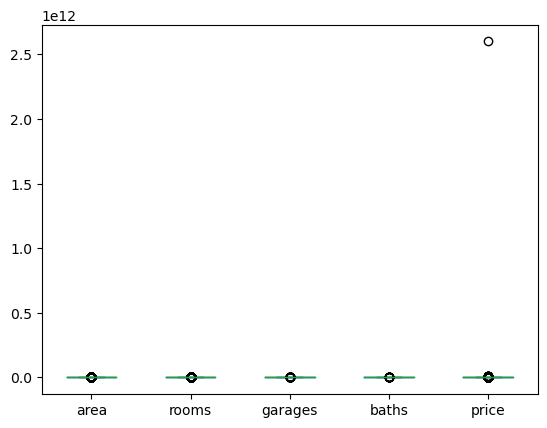

In [8]:
data.plot(kind='box')

## 2.2. Eliminación de Outliers

In [9]:
data = data[data['price'] < 1000000000]
data = data[data['area'] < 3000]

<Axes: >

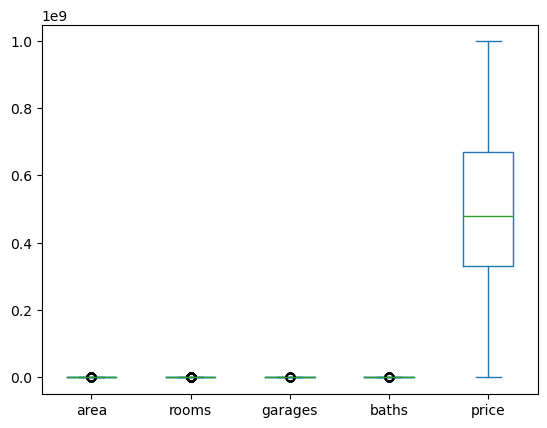

In [10]:
data.plot(kind='box')

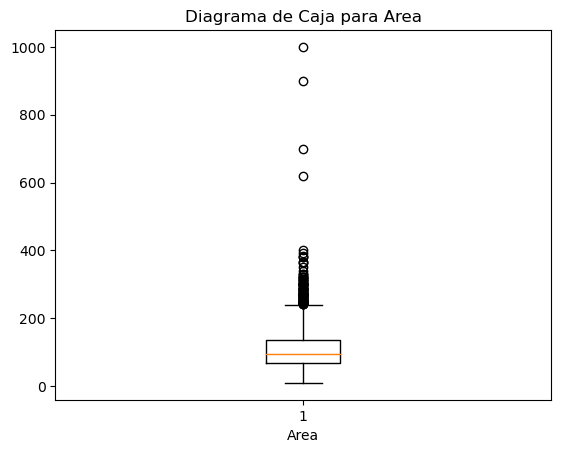

In [11]:
area= data['area']

plt.boxplot(area, vert=True)  # "vert=False" para un diagrama de caja horizontal
plt.xlabel('Area')  # Etiqueta del eje x (opcional)
plt.title('Diagrama de Caja para Area')  # Título del gráfico (opcional)
plt.show()


In [12]:
data['property_type'].unique()

array(['Apartamento', 'Casa', 'Casa Lote', 'Casa Campestre', 'Finca',
       'Apartaestudio', 'Lote'], dtype=object)

In [13]:
opciones_permitidas = ['Apartamento', 'Casa', 'Apartaestudio']
data = data[data['property_type'].isin(opciones_permitidas)]

In [14]:
data['property_type']=data['property_type'].astype('category')
data['property_type'].unique()

/var/folders/j7/rwvm0qwd5yng5w440jzc67jm0000gn/T/ipykernel_2945/3221102709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['property_type']=data['property_type'].astype('category')


['Apartamento', 'Casa', 'Apartaestudio']
Categories (3, object): ['Apartaestudio', 'Apartamento', 'Casa']

## 2.3. Variables Dummies

In [15]:
#Sklearn sólo analiza variables numéricas
data = pd.get_dummies(data, columns=['stratum','property_type','neighbourhood','city'], drop_first=False, dtype='int64')
data.head()

,area,rooms,garages,baths,price,stratum_Campestre,stratum_Estrato 0,stratum_Estrato 1,stratum_Estrato 2,stratum_Estrato 3,...,neighbourhood_San Javier,neighbourhood_San Lucas,neighbourhood_San german,neighbourhood_Santa Mónica,neighbourhood_Santa maria de los angeles,neighbourhood_Simon bolivar,neighbourhood_Urbanizacion doña maria robledo,neighbourhood_Urbanizacion vegas del poblado,neighbourhood_Velodromo,city_Medellín
2,81,3,1,2,510000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,92,3,1,2,475000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,105,4,2,4,650000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,76,3,1,2,650000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,86,3,2,2,550000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3212 entries, 2 to 7742
Data columns (total 69 columns):
 #   Column                                         Non-Null Count  Dtype
---  ------                                         --------------  -----
 0   area                                           3212 non-null   int64
 1   rooms                                          3212 non-null   int64
 2   garages                                        3212 non-null   int64
 3   baths                                          3212 non-null   int64
 4   price                                          3212 non-null   int64
 5   stratum_Campestre                              3212 non-null   int64
 6   stratum_Estrato 0                              3212 non-null   int64
 7   stratum_Estrato 1                              3212 non-null   int64
 8   stratum_Estrato 2                              3212 non-null   int64
 9   stratum_Estrato 3                              3212 non-null   int64
 10  strat

# 3. División de los datos 70-30

<Axes: ylabel='Frequency'>

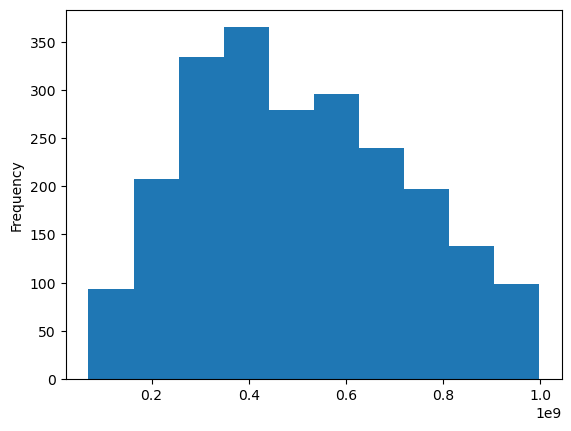

In [17]:
#División 70-30
X = data.drop("price", axis = 1) # Variables predictoras
Y = data['price'] #Variable objetivo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
Y_train.plot(kind='hist')

# 4. Hiperparametrización

## 4.1. Modelo árbol

In [18]:
#  Arbol
modelTree = DecisionTreeRegressor()

# Definir los hiperparametros
criterion=['squared_error','absolute_error'] #Indice de información
min_samples_leaf=[2,10,50,80,100,130] # Cantidad de registros por hoja
max_depth=[None, 10,20, 50,80,100] #Niveles de profundidad

#Grid
param_grid = dict(criterion=criterion, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
grid = GridSearchCV(estimator=modelTree, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
grid.fit(X_train, Y_train)

#Mejor modelo
modelTree= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas_CV= pd.DataFrame(index=['MSE'])
medidas_CV['Tree']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas_CV)

{'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10}
                        Tree
MSE -11924933048273750.00000


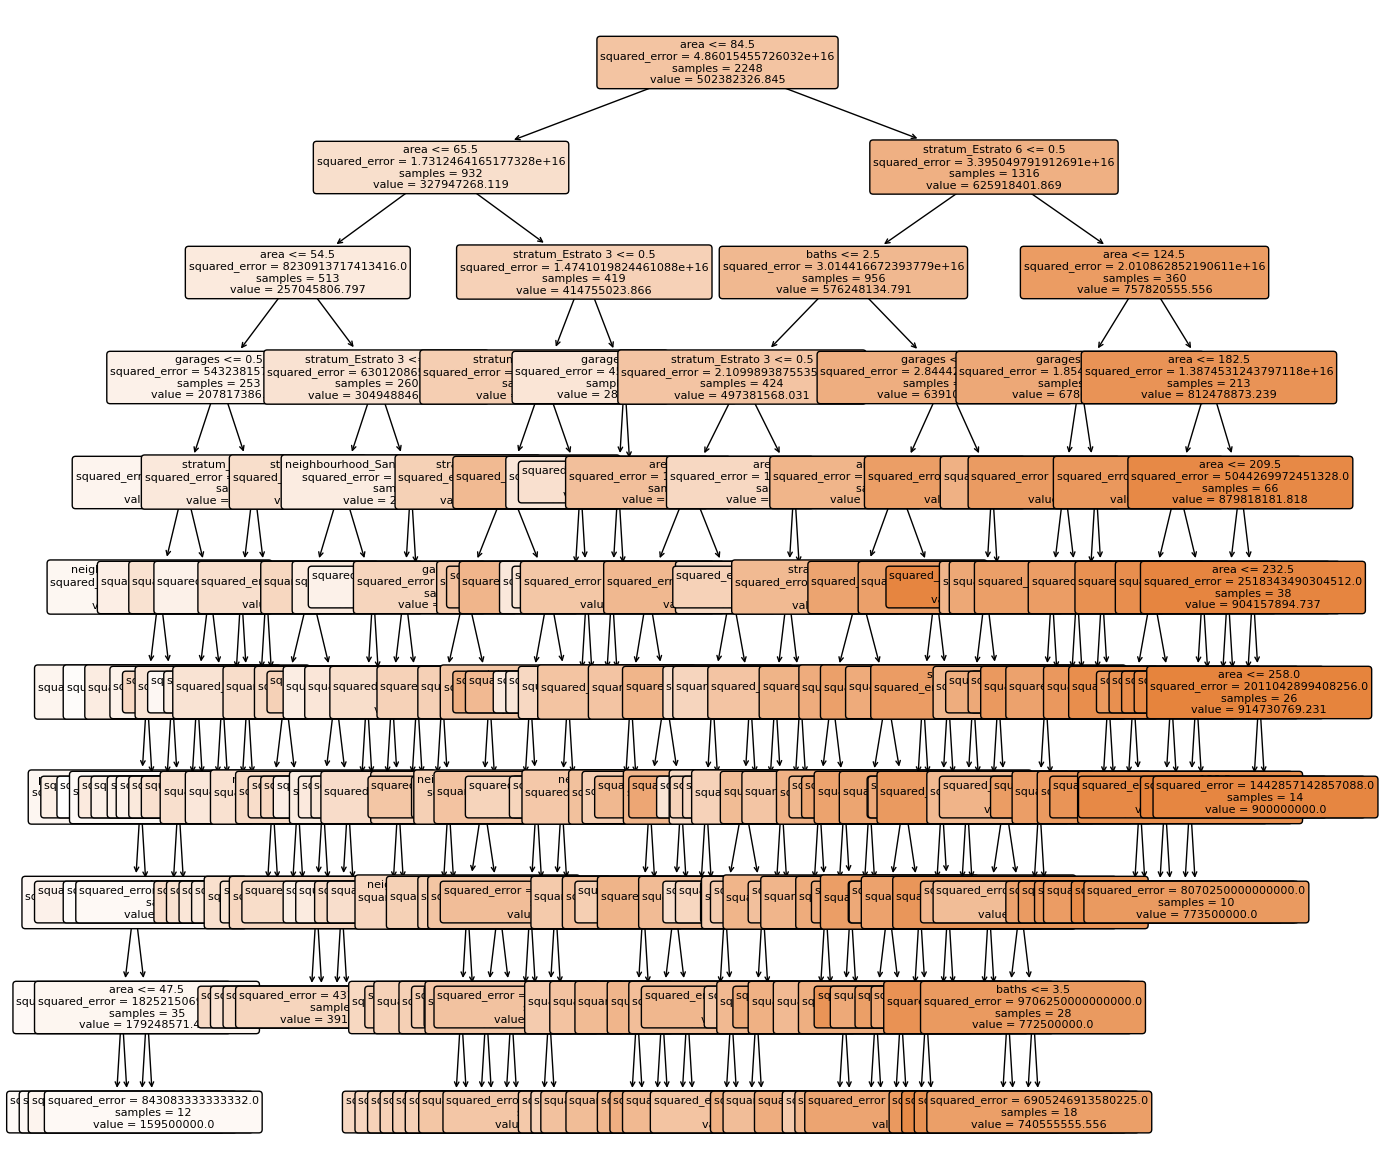

In [19]:
plt.figure(figsize=(15,15))
plot_tree(modelTree, feature_names=X_train.columns.values, rounded=True, filled=True, fontsize=8)
plt.show()

## 4.2. Normalización de las variables numéricas

In [20]:
#Normalizacion las variables numéricas (las dummies no se normalizan)
min_max_scaler = MinMaxScaler()
variables_norm=['area',	'rooms','baths','garages']
min_max_scaler.fit(data[variables_norm]) #Ajuste de los parametros: max - min

#Se aplica la normalización a 70%  y el 30% se normaliza posteriormente
X_train[variables_norm]= min_max_scaler.transform(X_train[variables_norm]) #70%
X_train.head()

,area,rooms,garages,baths,stratum_Campestre,stratum_Estrato 0,stratum_Estrato 1,stratum_Estrato 2,stratum_Estrato 3,stratum_Estrato 4,...,neighbourhood_San Javier,neighbourhood_San Lucas,neighbourhood_San german,neighbourhood_Santa Mónica,neighbourhood_Santa maria de los angeles,neighbourhood_Simon bolivar,neighbourhood_Urbanizacion doña maria robledo,neighbourhood_Urbanizacion vegas del poblado,neighbourhood_Velodromo,city_Medellín
212,0.10662,0.33333,0.09091,0.22222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3723,0.04602,0.11111,0.09091,0.11111,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3918,0.09091,0.22222,0.09091,0.22222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
506,0.10213,0.22222,0.09091,0.11111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1073,0.08866,0.22222,0.09091,0.11111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 4.3. Modelo KNN

In [21]:
#KNN
modelKnn = KNeighborsRegressor()

# Definir los hiperparametros
n_neighbors=[1,3,5,7,13,27,41,53]
metric=['euclidean','minkowski']

#Grid
param_grid = dict(n_neighbors=n_neighbors, metric=metric)
grid = GridSearchCV(estimator=modelKnn, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1,cv=10)
grid.fit(X_train, Y_train) #70%

#Mejor modelo
modelKnn= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas_CV['Knn']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas_CV)

{'metric': 'euclidean', 'n_neighbors': 13}
                        Tree                      Knn
MSE -11924933048273750.00000 -12959209688612364.00000


## 4.4. Modelo Red Neuronal

In [22]:
#Red Neuronal
modelNN = MLPRegressor()

# Definir los parametros
random_state=[1] #Semilla para generar número pseudoaleatorios
solver=['adam']# Regla de aprendizaje ['adam','sgd','lbfgs']
learning_rate=['adaptive'] #tasa de aprendizaje
learning_rate_init=[0.2, 0.5, 1.0, 1.5] #valor tasa de aprendizaje
momentum=[0.3, 0.5, 1.0] #momentum
activation=['identity','relu'] #'identity’, ‘logistic’, ‘tanh’, ‘relu’
hidden_layer_sizes=[4, 20,30,[8, 20]] # neuronas de la capa oculta ((input+output)/2)
max_iter = [100,200,500] #iteraciones

#Grid
param_grid = dict(random_state=random_state,solver=solver,activation=activation, hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, learning_rate=learning_rate,
                  learning_rate_init=learning_rate_init, momentum=momentum)
grid = GridSearchCV(estimator=modelNN, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
grid.fit(X_train, Y_train)

#Mejor modelo
modelNN= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas_CV['NN']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas_CV)

/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't conv

{'activation': 'identity', 'hidden_layer_sizes': [8, 20], 'learning_rate': 'adaptive', 'learning_rate_init': 0.5, 'max_iter': 200, 'momentum': 0.3, 'random_state': 1, 'solver': 'adam'}
                        Tree                      Knn                       NN
MSE -11924933048273750.00000 -12959209688612364.00000 -11767431216096630.00000


/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 4.5. Modelo SVM

In [23]:
#SVM
modelSVM = SVR()

# Definir los hiperparametros
C=[0.1,1,10] #Margen blando
kernel=['linear', 'rbf'] #'linear', 'poly', 'rbf', 'sigmoid'
gamma=['scale','auto',0.01,5]

#Grid
param_grid = dict(C=C, kernel=kernel,gamma=gamma)
grid = GridSearchCV(estimator=modelSVM, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
grid.fit(X_train, Y_train)

#Mejor modelo
modelSVM= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas_CV['SVM']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas_CV)

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
                        Tree                      Knn  \
MSE -11924933048273750.00000 -12959209688612364.00000   

                          NN                      SVM  
MSE -11767431216096630.00000 -49578719717611536.00000  


## 4.6. Modelo Bagging

In [24]:
#Bagging
model_bag = BaggingRegressor()

# Definir los hiperparametros
base_knn= KNeighborsRegressor(n_neighbors=1, metric='euclidean')
base_nn= MLPRegressor(activation="logistic",hidden_layer_sizes=(10), learning_rate='adaptive',
                      learning_rate_init=0.2, momentum= 0.3, max_iter=500, verbose=False)

base_estimator=[base_knn, base_nn] #Métodos de Machine Learning
n_estimators=[10,50,100]
max_samples=[0.6,0.7,0.8]

#Grid
param_grid = dict(base_estimator=base_estimator, n_estimators=n_estimators,max_samples=max_samples)
grid = GridSearchCV(estimator=model_bag, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=10)
grid.fit(X_train, Y_train)

#Mejor modelo
model_bag= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas_CV['Bagging']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas_CV)

/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimato

{'base_estimator': KNeighborsRegressor(metric='euclidean', n_neighbors=1), 'max_samples': 0.6, 'n_estimators': 100}
                        Tree                      Knn  \
MSE -11924933048273750.00000 -12959209688612364.00000   

                          NN                      SVM                  Bagging  
MSE -11767431216096630.00000 -49578719717611536.00000 -12912819440366920.00000  


/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/samuelperezh/anaconda3/envs/upb/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


# 5. Evaluación

                       Arbol
mse  13287814944623626.00000
rmse         115272784.92612
mae           85787868.64690
mape                 0.33276
max          568894736.84211


/var/folders/j7/rwvm0qwd5yng5w440jzc67jm0000gn/T/ipykernel_2945/2994267409.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


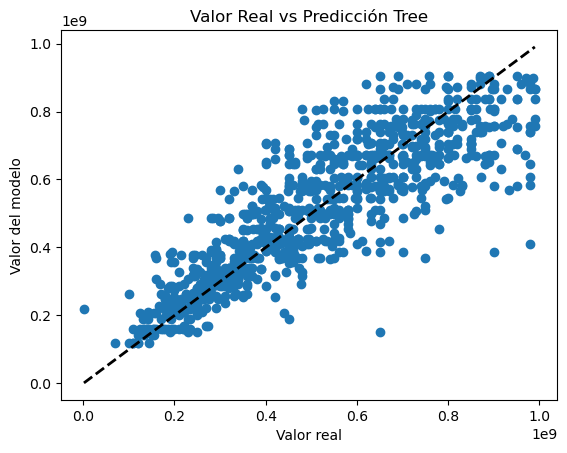

In [25]:
#Evaluación del árbol de regresión 30%
Y_pred = modelTree.predict(X_test) #30%

#Dataframe para comparar los resultados
medidas= pd.DataFrame(index=['mse','rmse','mae','mape','max'])

mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['Arbol']=[mse, rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Tree')
plt.show() # Mostrar la grafica luego de que ya se definio todos los elementos

In [26]:
#Se normaliza X_test para el resto de métodos
X_test[variables_norm]= min_max_scaler.transform(X_test[variables_norm])  #30%
X_test

,area,rooms,garages,baths,stratum_Campestre,stratum_Estrato 0,stratum_Estrato 1,stratum_Estrato 2,stratum_Estrato 3,stratum_Estrato 4,...,neighbourhood_San Javier,neighbourhood_San Lucas,neighbourhood_San german,neighbourhood_Santa Mónica,neighbourhood_Santa maria de los angeles,neighbourhood_Simon bolivar,neighbourhood_Urbanizacion doña maria robledo,neighbourhood_Urbanizacion vegas del poblado,neighbourhood_Velodromo,city_Medellín
6654,0.08866,0.00000,0.18182,0.11111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2877,0.23232,0.33333,0.09091,0.33333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7073,0.16274,0.22222,0.09091,0.22222,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
340,0.08642,0.22222,0.18182,0.11111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
116,0.09540,0.22222,0.00000,0.11111,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4569,0.07856,0.22222,0.09091,0.11111,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3074,0.04489,0.11111,0.09091,0.00000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
801,0.09989,0.22222,0.00000,0.11111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
782,0.06958,0.00000,0.00000,0.11111,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


                       Arbol                     Knn
mse  13287814944623626.00000 15267836480393380.00000
rmse         115272784.92612         123563087.04623
mae           85787868.64690          92506117.22502
mape                 0.33276                 0.41134
max          568894736.84211         535769230.76923


/var/folders/j7/rwvm0qwd5yng5w440jzc67jm0000gn/T/ipykernel_2945/3165855749.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


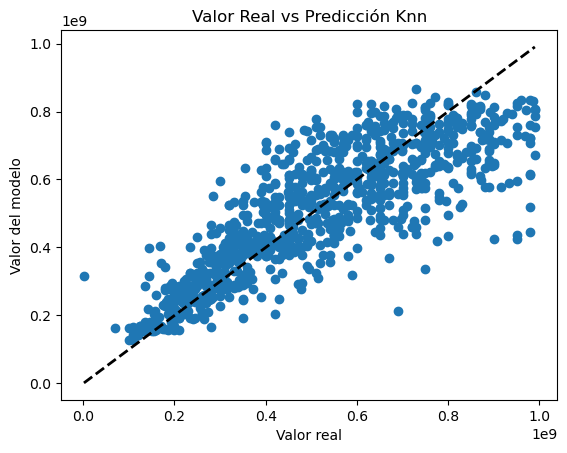

In [27]:
#Evaluación de Knn 30%
Y_pred = modelKnn.predict(X_test) #30%

#Medidas de error
mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['Knn']=[mse, rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Knn')
plt.show()

                       Arbol                     Knn                     NN
mse  13287814944623626.00000 15267836480393380.00000  1.208750098629428e+16
rmse         115272784.92612         123563087.04623        109943171.62195
mae           85787868.64690          92506117.22502         84084228.68711
mape                 0.33276                 0.41134                0.35107
max          568894736.84211         535769230.76923        484222959.52337


/var/folders/j7/rwvm0qwd5yng5w440jzc67jm0000gn/T/ipykernel_2945/169064174.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


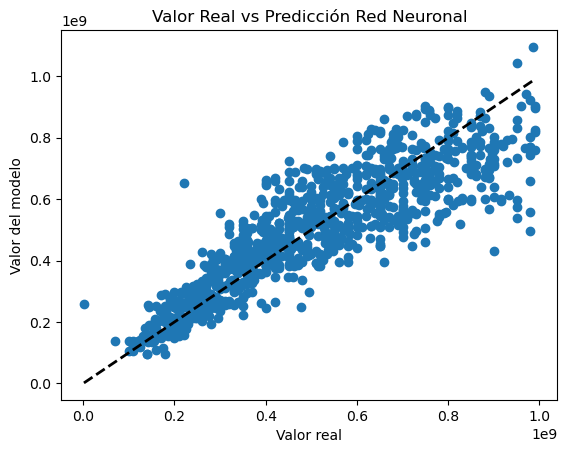

In [28]:
#Evaluación de NN con el 30%
Y_pred = modelNN.predict(X_test) #30%

#Medidas de error
mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['NN']=[format(mse), rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Red Neuronal')
plt.show()

                       Arbol                     Knn                     NN  \
mse  13287814944623626.00000 15267836480393380.00000  1.208750098629428e+16   
rmse         115272784.92612         123563087.04623        109943171.62195   
mae           85787868.64690          92506117.22502         84084228.68711   
mape                 0.33276                 0.41134                0.35107   
max          568894736.84211         535769230.76923        484222959.52337   

                         SVM  
mse  50355562865205112.00000  
rmse         224400452.01649  
mae          186490926.45670  
mape                 0.80336  
max          519992558.34524  


/var/folders/j7/rwvm0qwd5yng5w440jzc67jm0000gn/T/ipykernel_2945/692033304.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


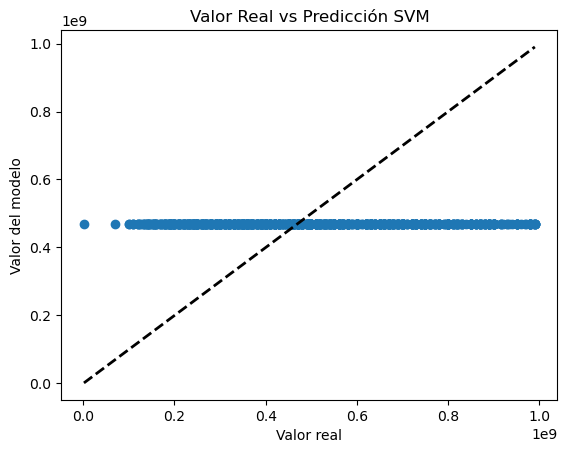

In [29]:
#Evaluación de SVM con el 30%
Y_pred = modelSVM.predict(X_test) #30%

#Medidas de error
mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['SVM']=[mse, rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción SVM')
plt.show()

                       Arbol                     Knn                     NN  \
mse  13287814944623626.00000 15267836480393380.00000  1.208750098629428e+16   
rmse         115272784.92612         123563087.04623        109943171.62195   
mae           85787868.64690          92506117.22502         84084228.68711   
mape                 0.33276                 0.41134                0.35107   
max          568894736.84211         535769230.76923        484222959.52337   

                         SVM                 Bagging  
mse  50355562865205112.00000 16399844074534604.00000  
rmse         224400452.01649         128061875.96055  
mae          186490926.45670          91361854.12177  
mape                 0.80336                 0.38403  
max          519992558.34524         614200000.00000  


/var/folders/j7/rwvm0qwd5yng5w440jzc67jm0000gn/T/ipykernel_2945/3523133513.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)


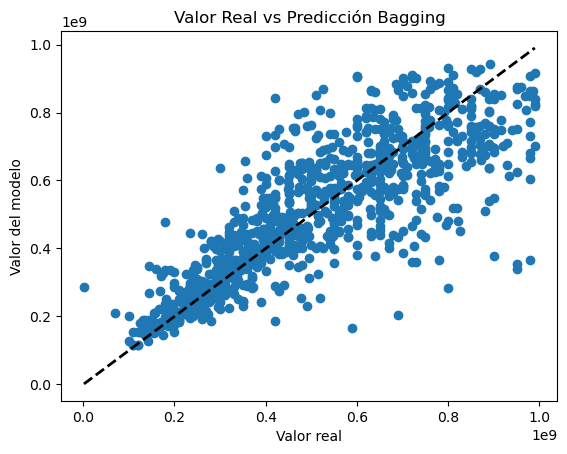

In [30]:
#Evaluación de Bagging con el 30%
Y_pred = model_bag.predict(X_test) #30%

#Medidas de error
mse = metrics.mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae= metrics.mean_absolute_error(Y_test,Y_pred)
mape=metrics.mean_absolute_percentage_error(Y_test,Y_pred)
max=metrics.max_error(Y_test,Y_pred)
medidas['Bagging']=[mse, rmse, mae, mape,max]
print(medidas)

#Gráfica Valor Real vs Predicción
plt.scatter(Y_test, Y_pred)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()],'k--', color = 'black', lw=2)
plt.xlabel('Valor real')
plt.ylabel('Valor del modelo')
plt.title('Valor Real vs Predicción Bagging')
plt.show()

In [31]:
medidas

,Arbol,Knn,NN,SVM,Bagging
mse,13287814944623626.00000,15267836480393380.00000,1.208750098629428e+16,50355562865205112.00000,16399844074534604.00000
rmse,115272784.92612,123563087.04623,109943171.62195,224400452.01649,128061875.96055
mae,85787868.64690,92506117.22502,84084228.68711,186490926.45670,91361854.12177
mape,0.33276,0.41134,0.35107,0.80336,0.38403
max,568894736.84211,535769230.76923,484222959.52337,519992558.34524,614200000.00000


# 6. Guardar el modelo

In [33]:
modelTree.fit(X, Y)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)

In [34]:
filename = 'data/modelo-PropyApp.pkl'
variables= X.columns._values
pickle.dump([modelTree,variables], open(filename, 'wb')) #write